# Sinkhorn divergence gradient flows

Let $\mathrm{OT_\varepsilon}(\alpha, \beta)$ the entropic regularized OT distance between two distributions $\alpha$ and $\beta$. One issue with $\mathrm{OT_\varepsilon}$ is that $\mathrm{OT_\varepsilon}(\alpha, \alpha)$ is not equal to 0.

The Sinkhorn divergence, defined in {cite}`genevay:18` as $\mathrm{S}_\varepsilon(\alpha, \beta) = \mathrm{OT_\varepsilon}(\alpha, \beta) - \frac{1}{2}\mathrm{OT_\varepsilon}(\alpha, \alpha) - \frac{1}{2}\mathrm{OT_\varepsilon}(\beta, \beta)$ removes this entropic bias.

In this tutorial we showcase the advantage of removing the entropic bias using gradient flows on 2-D distributions, as done in {cite}`feydy:19` and following the {doc}`point_clouds` tutorial.

## Imports

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence

/Users/michal/.mambaforge/envs/ott/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/michal/.mambaforge/envs/ott/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Defining two distributions

Let us start by defining simple source and target distributions.

In [3]:
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)

x = 0.25 * jax.random.normal(key1, (25, 2))  # Source
y = 0.5 * jax.random.normal(key2, (50, 2)) + jnp.array((6, 0))  # Target

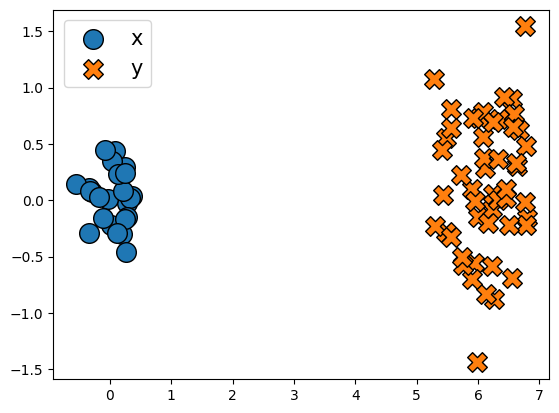

In [4]:
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", label="x", s=200)
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", label="y", s=200)
plt.legend(fontsize=15)
plt.show()

## Gradient flow with $\mathrm{OT}_\varepsilon$

As in the {doc}`point_clouds` tutorial, we now compute the gradient flow for the regularized OT cost using the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm.

The code below performs gradient descent to move the points of $x$ in a way that minimizes the regularized OT cost.

In [5]:
def gradient_flow(
    x: jnp.ndarray,
    y: jnp.ndarray,
    cost_fn: callable,
    num_iter: int = 500,
    lr: float = 0.2,
    dump_every: int = 50,
    epsilon: float = None,
):
    """Compute a gradient flow."""

    ots = []

    # Apply jax.value_and_grad operator and jit that function.
    cost_fn_vg = jax.jit(jax.value_and_grad(cost_fn, has_aux=True))

    # Perform gradient descent on `x`.
    for i in range(0, num_iter + 1):
        # Define the geometry, then compute the OT cost and its gradient.
        geom = pointcloud.PointCloud(x, y, epsilon=epsilon)
        (cost, ot), geom_g = cost_fn_vg(geom)
        assert ot.converged

        x = x - geom_g.x * lr  # Perform a gradient descent step.
        if i % dump_every == 0:
            ots.append(ot)  # Save the current state of the optimization.

    return ots

In [6]:
def display_animation(ots, plot_class=plot.Plot):
    """Display an animation of the gradient flow."""
    plott = plot_class(show_lines=False)
    anim = plott.animate(ots, frame_rate=4)
    html = display.HTML(anim.to_jshtml())
    display.display(html)
    plt.close()

In [7]:
def reg_ot_cost(geom):
    """Return the OT cost and OT output given a geometry"""
    ot = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
    return ot.reg_ot_cost, ot

For the default value of $\varepsilon$, the gradient flow behaves as expected:

In [8]:
# Compute and display the gradient flow for the regularized OT cost.
ots = gradient_flow(x, y, reg_ot_cost)
display_animation(ots)

But for a larger $\varepsilon$, the distribution collapses:

In [9]:
# Compute and display the gradient flow for a larger value of epsilon.
ots = gradient_flow(x, y, reg_ot_cost, epsilon=1.0)
display_animation(ots)

Let us fix this by optimizing instead the debiased quantity $\mathrm{S}_\varepsilon$.

## Gradient flow with $\mathrm{S}_\varepsilon$

By slightly adapting the previous function, we can compute the gradient flow using the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` instead of the regularized OT cost.

In [10]:
def sink_div(geom):
    """Return the Sinkhorn divergence cost and OT output given a geometry.
    Since y is fixed, we can use static_b=True to avoid computing
    the OT(b, b) term."""

    ot = sinkhorn_divergence.sinkhorn_divergence(
        geom,
        x=geom.x,
        y=geom.y,
        static_b=True,
    )
    return ot.divergence, ot

We also have to adapt the plotting object slightly to deal with the fact that we have Sinkhorn divergence outputs, which have multiple geometries.

In [11]:
class CustomPlot(plot.Plot):
    def _scatter(self, ot):
        x, y = ot.geoms[0].x, ot.geoms[0].y
        a, b = ot.a, ot.b
        scales_x = a * self._scale * a.shape[0]
        scales_y = b * self._scale * b.shape[0]
        return x, y, scales_x, scales_y

Thanks to the debiasing, the distributions overlap nicely for a larger $\varepsilon$.

In [12]:
# Compute and display the sinkhorn divergence gradient flow for the same large epsilon.
ots = gradient_flow(x, y, sink_div, epsilon=1.0)
display_animation(ots, plot_class=CustomPlot)